# Ex_08. 네이버 영화리뷰 감성분석 도전하기

In [1]:
import pandas as pd
import konlpy
import gensim
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)


1.4.4
0.6.0
4.1.2


## 1. 데이터 준비하기

In [2]:
train_data = pd.read_table('C:/users/juwon/practice_aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('C:/users/juwon/practice_aiffel/sentiment_classification/data/ratings_test.txt')
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [3]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
from eunjeon import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

## 2. load_data
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [6]:
def load_data(train_data, test_data, num_words=10000 ) :
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복데이터, 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document'] :
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X) # 토큰화해서 저장
    
    X_test = []
    for sentence in test_data['document'] :
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()  
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 사전 word_to_index 구성

    def wordlist_to_indexlist(wordlist): 
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist] 
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
word_to_index['<PAD>']=0
word_to_index['<BOS>']=1
word_to_index['<UNK>']=2
index_to_word = {index:word for word, index in word_to_index.items()} # index_to_word 구성

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+ sentence  # 이미 load_data로 벡터화를 했으므로 시작 벡터만 붙여준다.

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
X_train[0]

[32, 600, 4, 4, 39, 229, 20, 33, 745]

In [10]:
get_decoded_sentence(X_train[0], index_to_word)

'더빙 . . 진짜 짜증 나 네요 목소리'

In [11]:
X_train = get_encoded_sentences(X_train, word_to_index) # <BOS> 벡터를 문장앞에 붙여준다.
X_test = get_encoded_sentences(X_test, word_to_index)

In [12]:
print(X_train[0])
print(X_test[0])

[1, 32, 600, 4, 4, 39, 229, 20, 33, 745]
[1, 828, 131]


In [13]:
print(get_decoded_sentence(X_train[0], index_to_word))
print(get_decoded_sentence(X_test[0], index_to_word))

아 더빙 . . 진짜 짜증 나 네요 목소리
굳 ㅋ


## 3) 모델 구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [14]:
total_list = X_train + X_test
len(total_list)
num_token = [len(sentence) for sentence in total_list]
num_token = np.array(num_token)
print('문장길이 평균 : ', np.mean(num_token)) # 데이터셋 내 문장 길이 분포 확인해보기
print('문장길이 최대 : ', np.max(num_token))
print('문장길이 표준편차 : ', np.std(num_token))
maxtokens = np.mean(num_token)+3*np.std(num_token) # 최대 문장 길이 지정
maxlen = int(maxtokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_token < maxtokens) / len(num_token)))

문장길이 평균 :  16.972842084785935
문장길이 최대 :  117
문장길이 표준편차 :  12.843357707480491
pad_sequences maxlen :  55
전체 문장의 0.9720946661956905%가 maxlen 설정값 이내에 포함됩니다. 


In [15]:
import tensorflow as tf
X_train= tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                              value = word_to_index['<PAD>'],
                                             padding='post',
                                             maxlen=maxlen) 
X_test= tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                              value = word_to_index['<PAD>'],
                                             padding='post',
                                             maxlen=maxlen)

### 데이터 분리

In [16]:
# validation set 70000건 분리
X_val = X_train[:70000]   
y_val = y_train[:70000]

# validation set을 제외한 나머지
partial_x_train = X_train[70000:]  
partial_y_train = y_train[70000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(76182, 55)
(76182,)


In [17]:
print(len(X_train))
print(len(X_test))

146182
49157


## 4) 모델구성
### 4.1) LSTM 활용

In [2]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
# [[YOUR CODE]]
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size
                                    , word_vector_dim,input_shape=(None,)))
model.add(tf.keras.layers.LSTM(4))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(4, activation='relu'))
# model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dense(128, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

NameError: name 'tf' is not defined

In [3]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=7
with tf.device('/device:GPU:0') :
    history = model.fit(partial_x_train,
         partial_y_train,
         epochs = epochs,
         batch_size = 512,
         validation_data = (X_val, y_val),
         verbose=1)
    results = model.evaluate(X_test, y_test)
    print(results)

NameError: name 'model' is not defined

In [4]:
history_dict = history.history
history_dict.keys()

NameError: name 'history' is not defined

In [5]:
import matplotlib.pyplot as plt
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1,len(acc)+1)

plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs,val_loss, c='b', label = 'Val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: name 'history_dict' is not defined

In [ ]:
plt.plot(epochs, acc ,'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

검증셋의 정확도가 0.83에 수렴한다. epoch=4 부터 과대적합이 일어났다.

dim = 64 / 4 4  0.7931
dim = 32 / 16 32 64 128  0.834     
dim = 32 / 16 16  0.834    
dim = 32 / 8 8 8  0.836    
dim = 32 / 8 8  0.837    
dim = 32 / 4 4  0.83    
dim = 16 / 8 8  0.834    
dim = 8 / 8 8  0.835    
dim = 8 / 8 8 8  0.832    

evaluate 해본결과 acc는 0.83에 수렴했고, 더 올라가질 않는다. 워드벡터의 차원수가 풍부한 표현을 할 순 있지만 너무 많다고 해서 성능이 좋아지지는 않는 것 같다. 오히려 떨어진다.  또한 레이어를 깊게 쌓는것은 이번 데이터셋에서는 의미가 없어보인다. 평균적으로 epoch=3~4 부터 오버피팅이 일어났다. 은닉층이 얕고 노드수가 적을수록 좀 더 높은 acc가 나왔다.

## 4.2 1-D Convolution Neural Network

In [218]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 32   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, None, 32)          320000    
                                                                 
 dropout_24 (Dropout)        (None, None, 32)          0         
                                                                 
 conv1d_58 (Conv1D)          (None, None, 32)          3104      
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, None, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_59 (Conv1D)          (None, None, 64)          6208      
                                                                 
 global_max_pooling1d_41 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                   

In [219]:
with tf.device('/device:CPU:0'):
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

    epochs=3

    history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (X_val, y_val),
                    verbose=1)
    results = model.evaluate(X_test, y_test)
print(results)

Epoch 1/3
149/149 [==============================] - 7s 45ms/step - loss: 0.5190 - accuracy: 0.7212 - val_loss: 0.3598 - val_accuracy: 0.8435
Epoch 2/3
149/149 [==============================] - 6s 40ms/step - loss: 0.3400 - accuracy: 0.8545 - val_loss: 0.3446 - val_accuracy: 0.8493
Epoch 3/3
1537/1537 [==============================] - 3s 2ms/step - loss: 0.3546 - accuracy: 0.8450
[0.35460802912712097, 0.8449661135673523]


In [220]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

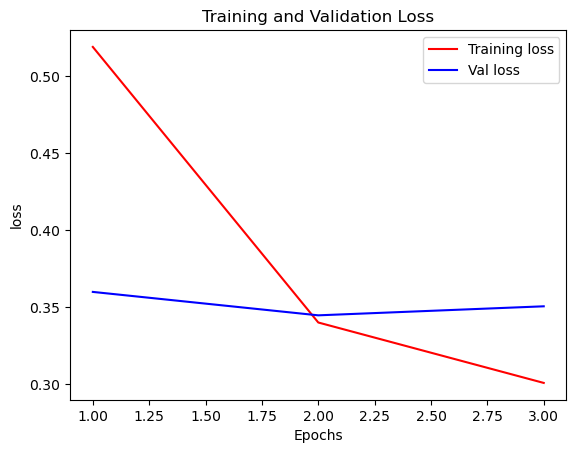

In [221]:
import matplotlib.pyplot as plt
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1,len(acc)+1)

plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs,val_loss, c='b', label = 'Val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

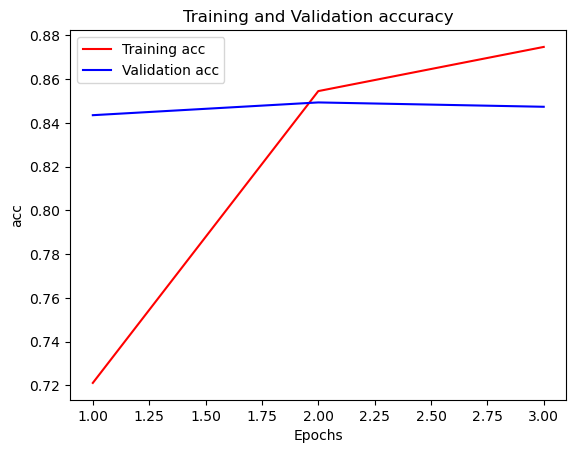

In [222]:
plt.plot(epochs, acc ,'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

dim = 16 (8,7) (8,7) 8 0.8418    
dim = 16 (16,7) (16,7) 8 0.8359    
dim = 16 (16,7) (32,7) 0.8347    
dim =16 (32,7) (64,7) 0.8367    
dim= 16 (4,5) (4,50 0.8402    
dim = 16 (8,3) (8,3) 8 0.8406    
dim = 16 (16,3) (16,3) 16 0.8404    
dim = 16 (16,7) (32,7) 16 0.8368

dim = 32 (16,4) (32,4) 16 0.845
dim = 32 (32,4) (64,4) 16 0.842
dim = 32 (32,4) (64,4) 16 0.842
dim = 32 (32,4) (64,4) 32 (dropout = 0.2) 0.848
dim = 32 (32,4) (64,4) 64 (dropout = 0.3, 0.2) 0.8521

acc는 Dense를 사용했을 때 보다 전체적으로 높았다. filter가 많을수록 마지막 은닉층의 Dense의 노드가 많을수록 정확도가 올라갔다.
kernel의 경우 7보단 3,4일때 보다 높게 나왔다. 과적합이 적은 epoch에서 일어나서 epoch을 줄였다. 과적합 해결을 위해 dropout레이어를 추가했다. 임베딩레이어 다음과 마지막 층으로 들어가기전에 한 번 더 걸러주었다. Dropout을 사용하였더니 acc가 증가하였다. 

### 4.3 GlobalMaxPooling1D 만 사용해보기

In [159]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 8   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, None, 8)           80000     
                                                                 
 dropout_3 (Dropout)         (None, None, 8)           0         
                                                                 
 global_max_pooling1d_29 (Gl  (None, 8)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_58 (Dense)            (None, 16)                144       
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________

In [160]:
with tf.device('/device:CPU:0'):
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

    epochs=5

    history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (X_val, y_val),
                    verbose=1)
    results = model.evaluate(X_test, y_test)
print(results)

Epoch 1/5
149/149 [==============================] - 2s 11ms/step - loss: 0.6579 - accuracy: 0.7004 - val_loss: 0.5922 - val_accuracy: 0.7610
Epoch 2/5
149/149 [==============================] - 1s 8ms/step - loss: 0.5101 - accuracy: 0.7788 - val_loss: 0.4566 - val_accuracy: 0.7996
Epoch 3/5
149/149 [==============================] - 1s 8ms/step - loss: 0.4246 - accuracy: 0.8107 - val_loss: 0.4126 - val_accuracy: 0.8176
Epoch 4/5
149/149 [==============================] - 1s 7ms/step - loss: 0.3955 - accuracy: 0.8257 - val_loss: 0.4011 - val_accuracy: 0.8225
Epoch 5/5
1537/1537 [==============================] - 2s 1ms/step - loss: 0.4024 - accuracy: 0.8189
[0.40238264203071594, 0.818886399269104]


In [161]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

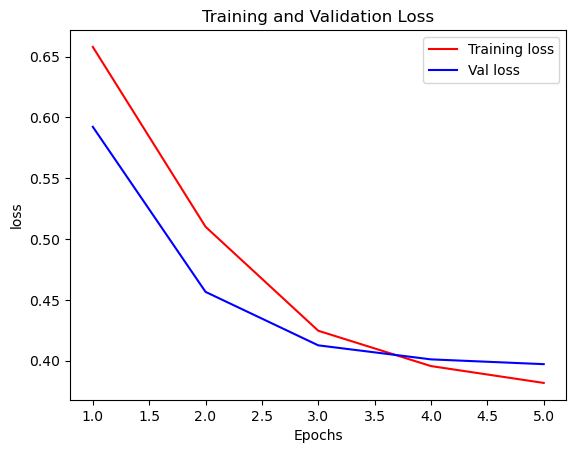

In [162]:
import matplotlib.pyplot as plt
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1,len(acc)+1)

plt.plot(epochs, loss, c='r', label='Training loss')
plt.plot(epochs,val_loss, c='b', label = 'Val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

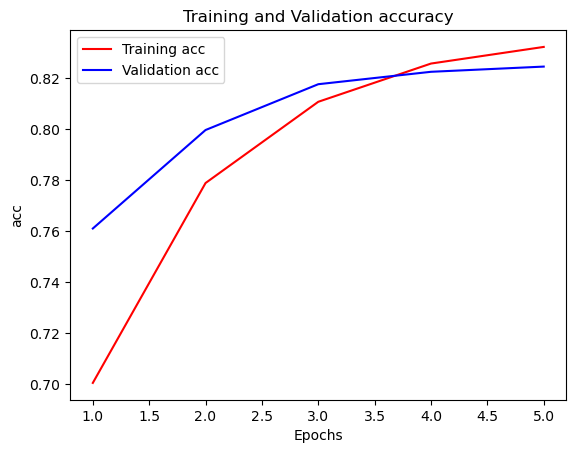

In [163]:
plt.plot(epochs, acc ,'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

dim = 32 16 0.842    
dim = 16 16 0.839    
dim = 8 16 0.823    
dim = 32 32 0.84    